In [86]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth 
from oauth2client.client import GoogleCredentials

In [87]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [88]:
from google.colab import drive
drive.mount('/content/ym')

Drive already mounted at /content/ym; to attempt to forcibly remount, call drive.mount("/content/ym", force_remount=True).


**Memory footprint support libraries/code**

In [89]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

# XXX: only one GPU on Colab and isn’t guaranteed

gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 10.6 GB  | Proc size: 4.0 GB
GPU RAM Free: 7036MB | Used: 4405MB | Util  39% | Total 11441MB


**To avoid colab 30/90 mins interruption**

In [90]:


'''
function ClickConnect(){

console.log("Working");

document.querySelector("colab-toolbar-button#connect").click()

}

setInterval(ClickConnect,60000)

'''


'\nfunction ClickConnect(){\n\nconsole.log("Working");\n\ndocument.querySelector("colab-toolbar-button#connect").click()\n\n}\n\nsetInterval(ClickConnect,60000)\n\n'

# **Working with images along with labels** 

In [91]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from numpy.random import seed

import keras
from keras.utils import np_utils
from  tensorflow.keras.utils import to_categorical


from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


import seaborn as sns

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam


from skimage.transform import resize
import time


**for consistemt results across multiple executions**

In [92]:
seed(3)
tf.random.set_seed(3)

**Images loading** 

In [93]:
dir='/content/ym/MyDrive/Colab Notebooks/CV/Leukemia detection/Datasets/ALL_IDB/ALL_IDB2/img/'

data = []
counter = 0

for img in os.listdir(dir):

  url = dir + img 
  counter += 1

  if "_1" in img:

    print(" Counter >>>  ", counter, " >>> Image file name >>>  ", img," >>> Image url >>>  ",url," >>>  Type or label ", ">>> ALL (For 1) ")  
    data.append((url,1))   
    
  else:    

    print(" Counter >>>  ", counter, " >>> Image file name >>>  ", img," >>> Image url >>>  ",url," >>>  Type or label ", ">>> Non ALL (For 0) ")  
    data.append((url,0))
    
data = pd.DataFrame(data,columns=['image','label'],index = None)
data = data.sample(frac=1.).reset_index(drop=True)

#data.tail()

 Counter >>>   1  >>> Image file name >>>   Im002_1.tif  >>> Image url >>>   /content/ym/MyDrive/Colab Notebooks/CV/Leukemia detection/Datasets/ALL_IDB/ALL_IDB2/img/Im002_1.tif  >>>  Type or label  >>> ALL (For 1) 
 Counter >>>   2  >>> Image file name >>>   Im010_1.tif  >>> Image url >>>   /content/ym/MyDrive/Colab Notebooks/CV/Leukemia detection/Datasets/ALL_IDB/ALL_IDB2/img/Im010_1.tif  >>>  Type or label  >>> ALL (For 1) 
 Counter >>>   3  >>> Image file name >>>   Im011_1.tif  >>> Image url >>>   /content/ym/MyDrive/Colab Notebooks/CV/Leukemia detection/Datasets/ALL_IDB/ALL_IDB2/img/Im011_1.tif  >>>  Type or label  >>> ALL (For 1) 
 Counter >>>   4  >>> Image file name >>>   Im024_1.tif  >>> Image url >>>   /content/ym/MyDrive/Colab Notebooks/CV/Leukemia detection/Datasets/ALL_IDB/ALL_IDB2/img/Im024_1.tif  >>>  Type or label  >>> ALL (For 1) 
 Counter >>>   5  >>> Image file name >>>   Im013_1.tif  >>> Image url >>>   /content/ym/MyDrive/Colab Notebooks/CV/Leukemia detection/Datas

In [94]:
print("Printing the data frame")

data

Printing the data frame


,image,label
0,/content/ym/MyDrive/Colab Notebooks/CV/Leukemi...,1
1,/content/ym/MyDrive/Colab Notebooks/CV/Leukemi...,1
2,/content/ym/MyDrive/Colab Notebooks/CV/Leukemi...,0
3,/content/ym/MyDrive/Colab Notebooks/CV/Leukemi...,1
4,/content/ym/MyDrive/Colab Notebooks/CV/Leukemi...,1
...,...,...
255,/content/ym/MyDrive/Colab Notebooks/CV/Leukemi...,1
256,/content/ym/MyDrive/Colab Notebooks/CV/Leukemi...,0
257,/content/ym/MyDrive/Colab Notebooks/CV/Leukemi...,1
258,/content/ym/MyDrive/Colab Notebooks/CV/Leukemi...,0


**Export the dataframe** 

In [95]:
data.to_csv(r'/content/ym/MyDrive/Colab Notebooks/CV/Leukemia detection/Output/Data.csv', index = False)


In [96]:
len(data)

260

In [97]:
def find_contour(cnts):
    contains = []
    y_ri = 256
    x_ri = 256
    for cc in cnts:
        yn = cv2.pointPolygonTest(cc,(x_ri//2,y_ri//2),False)
        contains.append(yn)

    val = [contains.index(temp) for temp in contains if temp>0]
    print(contains)
    return val[0]

In [98]:
def mask_generation_1(img):

    print(img.shape)
    gs = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY).astype(np.uint8)

    #k = 0.03
    #img2_sigm = (255/(1+np.exp(-k*(gs.astype(np.int32)-127)))).astype(np.uint8)
    

    blur = cv2.GaussianBlur(gs, (15,15),0)


    ret_otsu,im_bw_otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)


    kernel = np.ones((10,10),np.uint8)
    closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)
    #closing = clear_border(closing)


    contours, hierarchy = cv2.findContours(closing,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    


    black_img = np.empty([256,256,3],dtype=np.uint8)
    black_img.fill(0)

    index = find_contour(contours)
    cnt = contours[index]
    mask = cv2.drawContours(black_img, [cnt] , 0, (255,255,255), -1)

    return mask 

In [99]:
def images_with_masks (dataframe,dim):

    print(' Processing images and mask')
  
    n = len(dataframe)
 
    print('len ', n)

 
    images = np.zeros((n,dim,dim,3),dtype = np.float32)
    print(" Image shape  ",images.shape)
 
    masks = np.zeros((n,dim,dim,1),dtype = np.float32)
    print(" Mask label shape  ",masks.shape)
 
 
    for j in range(0,n):
 
        img_name = dataframe.iloc[j]['image']
        print(img_name)
        label = dataframe.iloc[j]['label']
 
        print('img_name ', img_name)
        print('mask label value  ', label)


        img = cv2.imread(img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(dim,dim))


      #  if img.shape[2]==1:
      #     img = np.dstack([img, img, img])
      #     print('img ', img)
 

        if label == 0:

           print(' Mask generation for non lymphocyte cells')

           mask = np.empty([dim,dim,3],dtype=np.uint8)
           mask.fill(0)

           print(' Mask gen', mask.shape)

           mask = cv2.cvtColor(mask,cv2.COLOR_RGB2GRAY)
           mask = resize(mask, (dim, dim, 1), mode='constant', preserve_range=True)
           print(' Maskdd gen', mask.shape)

           orig_img = img.astype(np.float32)/255.00
           images[j] = orig_img



           mask = mask.astype(np.float32)/255.00
           masks[j] = mask


        else:


          print(' Mask generation for lymphocyte cells')

          mask = mask_generation_1 (img)
          print('maslk', mask.shape)

          mask = cv2.cvtColor(mask,cv2.COLOR_RGB2GRAY)
          mask = resize(mask, (dim, dim, 1), mode='constant', preserve_range=True)
          print('maslyyyyyk', mask.shape)


          orig_img = img.astype(np.float32)/255.00
          images[j] = orig_img

          mask = mask.astype(np.float32)/255.00
          masks[j] = mask

      
    return images,masks

In [100]:
images, masks = images_with_masks(data,dim=256)

 Processing images and mask
len  260
 Image shape   (260, 256, 256, 3)
 Mask label shape   (260, 256, 256, 1)
/content/ym/MyDrive/Colab Notebooks/CV/Leukemia detection/Datasets/ALL_IDB/ALL_IDB2/img/Im001_1.tif
img_name  /content/ym/MyDrive/Colab Notebooks/CV/Leukemia detection/Datasets/ALL_IDB/ALL_IDB2/img/Im001_1.tif
mask label value   1
 Mask generation for lymphocyte cells
(256, 256, 3)
[1.0]
maslk (256, 256, 3)
maslyyyyyk (256, 256, 1)
/content/ym/MyDrive/Colab Notebooks/CV/Leukemia detection/Datasets/ALL_IDB/ALL_IDB2/img/Im065_1.tif
img_name  /content/ym/MyDrive/Colab Notebooks/CV/Leukemia detection/Datasets/ALL_IDB/ALL_IDB2/img/Im065_1.tif
mask label value   1
 Mask generation for lymphocyte cells
(256, 256, 3)
[1.0]
maslk (256, 256, 3)
maslyyyyyk (256, 256, 1)
/content/ym/MyDrive/Colab Notebooks/CV/Leukemia detection/Datasets/ALL_IDB/ALL_IDB2/img/Im228_0.tif
img_name  /content/ym/MyDrive/Colab Notebooks/CV/Leukemia detection/Datasets/ALL_IDB/ALL_IDB2/img/Im228_0.tif
mask label v

In [101]:
print('images dtype ', images.dtype)
print('images shape ', images.shape)

images dtype  float32
images shape  (260, 256, 256, 3)


In [102]:
print('masks dtype ', masks.dtype)
print('masks shape ', masks.shape)

masks dtype  float32
masks shape  (260, 256, 256, 1)


In [103]:
images = np.asarray(images)
masks = np.asarray(masks)

In [104]:
print('images dtype after np array ', images.dtype)
print('images shape after np array ', images.shape)

images dtype after np array  float32
images shape after np array  (260, 256, 256, 3)


In [105]:
print('masks dtype after np array ', masks.dtype)
print('masks shape after np array ', masks.shape)

masks dtype after np array  float32
masks shape after np array  (260, 256, 256, 1)


**Shuffle the images and the labels**

In [106]:
img,msk = shuffle(images,masks, random_state=3)
data_list = [img,msk]
type(data_list)


list

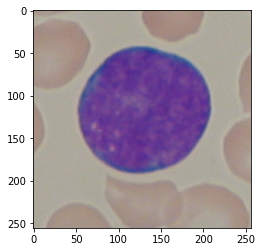

In [107]:
plt.imshow(img[0])
#print(msk[0])

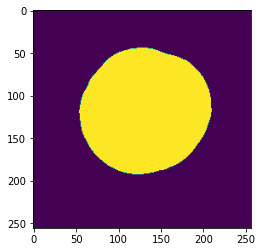

In [108]:
plt.imshow(msk[0].squeeze())

**Splitting into training and test set**


In [109]:

(X, y) = (data_list[0],data_list[1])

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=3)

In [110]:
print('X_train shape ', X_train.shape)
print('X_test shape  ', X_test.shape)
print('y_train shape ', y_train.shape)
print('y_test shape  ', y_test.shape)

X_train shape  (208, 256, 256, 3)
X_test shape   (52, 256, 256, 3)
y_train shape  (208, 256, 256, 1)
y_test shape   (52, 256, 256, 1)


In [111]:
print('X_train dtype ', X_train.size)
print('X_test dtype  ', X_test.dtype)
print('y_train dtype ', y_train.dtype)
print('y_test dtype  ', y_test.dtype)

X_train dtype  40894464
X_test dtype   float32
y_train dtype  float32
y_test dtype   float32


In [112]:
print('X_train dim ', X_train.ndim)
print('X_test dim  ', X_test.ndim)
print('y_train dim ', y_train.ndim)
print('y_test dim  ', y_test.ndim)

X_train dim  4
X_test dim   4
y_train dim  4
y_test dim   4


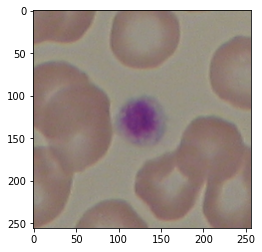

In [113]:
plt.imshow(X_test[10])
#print('train', X_train[0])

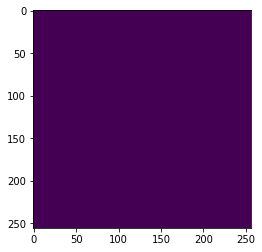

In [114]:
plt.imshow(y_test[10].squeeze())

**Visualizing  the  train images along with train masks** 

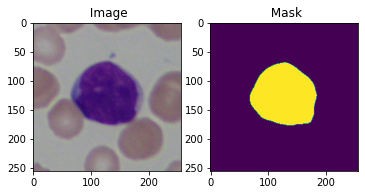

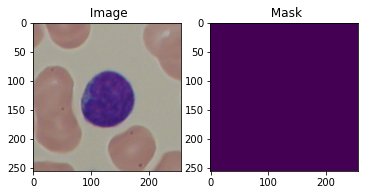

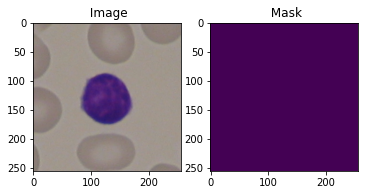

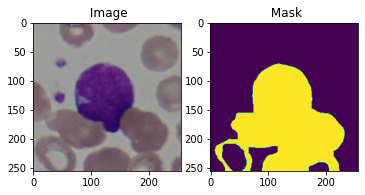

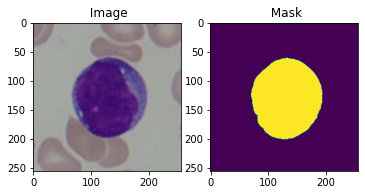

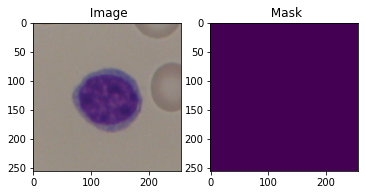

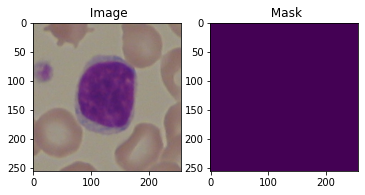

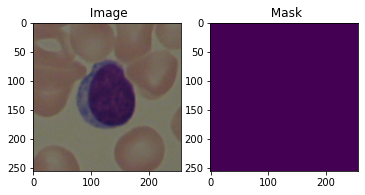

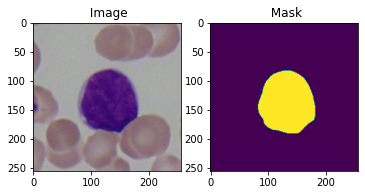

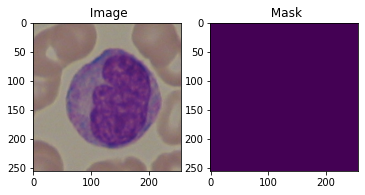

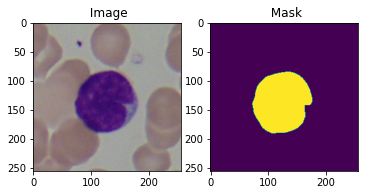

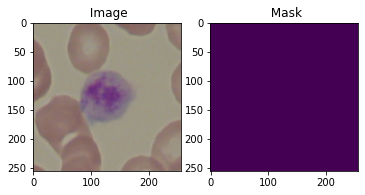

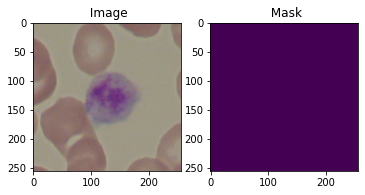

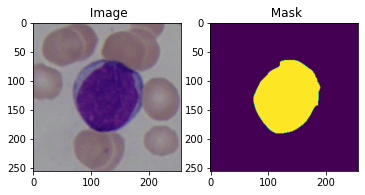

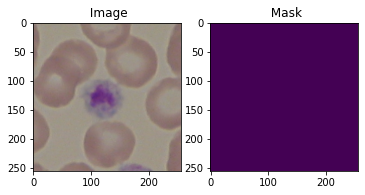

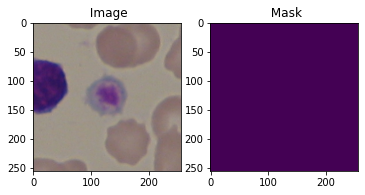

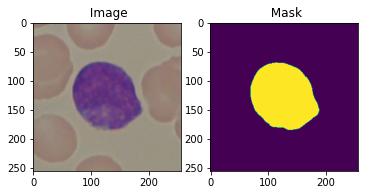

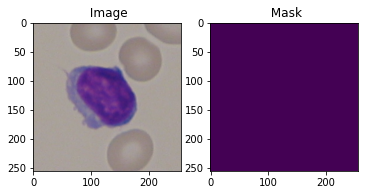

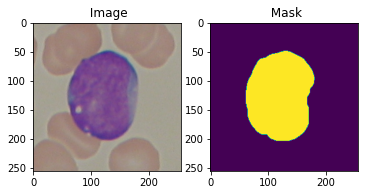

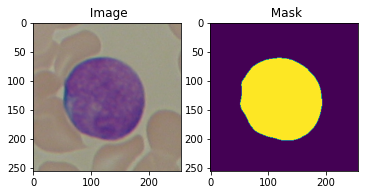

In [115]:
for i in range(20):

    img = X_train[i]
    groundTruth = y_train[i]

    plt.figure(figsize=(9,9))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title(' Image')

    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(groundTruth))
    plt.title(' Mask')

# **Unet model implementation** 

In [116]:
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [117]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH,3))
#s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
 
#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
 
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

 
#Expansive path 

 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
 
print('ffdfddfdf',c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
 
#outputs = tf.keras.layers.Flatten()(c9) 
#outputs = tf.keras.layers.Dense(2,activation = 'softmax')(outputs) 
 
#outputs= tf.keras.layers.Flatten()(outputs)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
 
model.summary()

ffdfddfdf KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 16), dtype=tf.float32, name=None), name='conv2d_46/Relu:0', description="created by layer 'conv2d_46'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_29 (Conv2D)             (None, 256, 256, 16  448         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_14 (Dropout)

In [118]:
print("Input Shape: ", inputs.shape)

Input Shape:  (None, 256, 256, 3)


In [119]:
print('Output Shape ',outputs.shape)

Output Shape  (None, 256, 256, 1)


**View the model architecture**

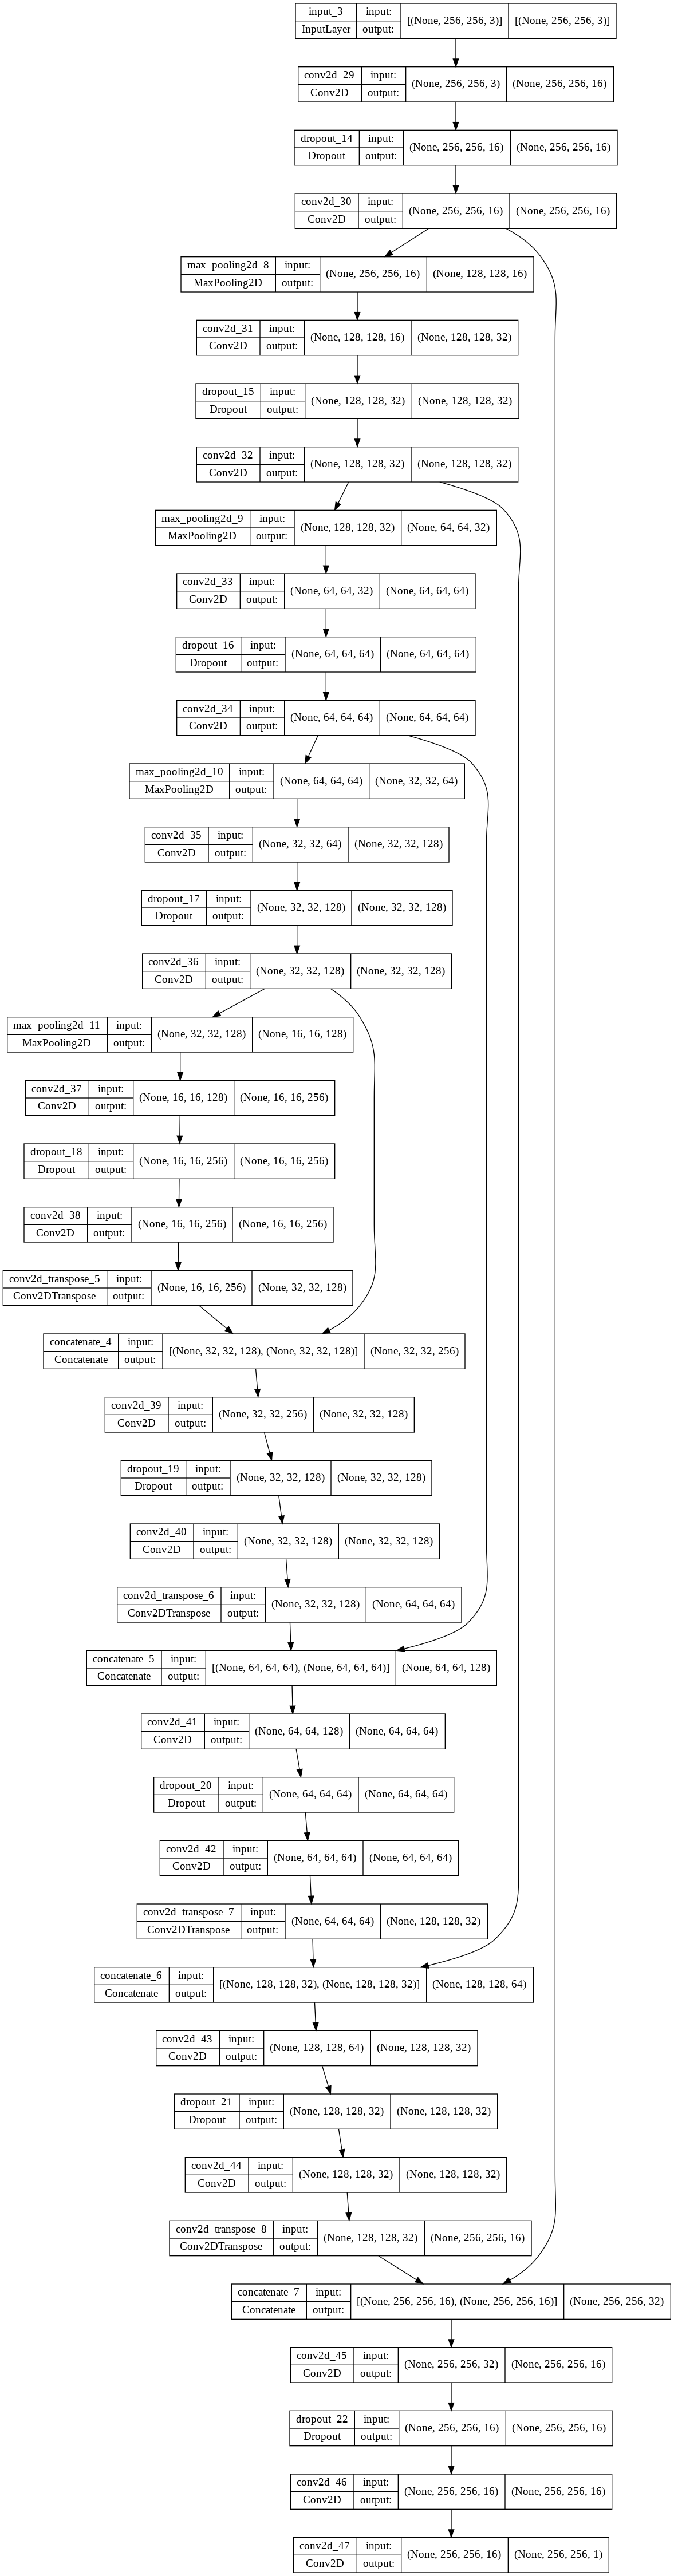

In [120]:
tf.keras.utils.plot_model(model, show_shapes=True)

**Defining Loss funtions**

In [121]:
smooth=100
 
def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))
 
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
 
def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac
 
def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
 
    return - iou(y_true, y_pred)


def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [122]:
batch_size = 16
epochs= 100

learning_rate = 1e-4
decay_rate = learning_rate / epochs

opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


**Compile the model**

In [123]:

model.compile(optimizer= opt, loss=dice_coef_loss, metrics=['accuracy', iou, dice_coef])

**Defining Callbacks**

In [124]:

timestr = time.strftime("%Y%m%d-%H%M%S")

filepath = '/content/ym/MyDrive/Colab Notebooks/Leukemia/Output/Weight_files/model_'+timestr+'_{epoch:02d}-{val_loss:.4f}.h5'

earlystopping =  EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 25,
                              verbose = 1)

checkpoint =  ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

learning_rate =  ReduceLROnPlateau(monitor = 'val_accuracy',
                                  mode = 'max',
                                  patience = 25,
                                  factor = 0.3,
                                  min_delta = 0.00001)

callback_list = [earlystopping, checkpoint, learning_rate]


**Data Augmentation**

In [125]:

data_aug = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split = 0.2)

#data_aug.fit(X_train)


**Fit the model**

In [126]:

start_time = time.time()

history = model.fit(X_train,y_train,batch_size,
                    steps_per_epoch = int(len(X_train)/batch_size),
                    validation_data = (X_test, y_test),    
                    validation_steps = int(len(X_test)/batch_size),            
                    verbose = 1,
                    callbacks = callback_list,
                    epochs= epochs)


end_time = time.time()
print(end_time - start_time)


Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: -0.1519 - accuracy: 0.4982 - iou: 0.0828 - dice_coef: 0.1519
Epoch 1: val_accuracy improved from -inf to 0.59290, saving model to /content/ym/MyDrive/Colab Notebooks/Leukemia/Output/Weight_files/model_20220410-081250_01--0.1451.h5
13/13 [==============================] - 9s 500ms/step - loss: -0.1519 - accuracy: 0.4982 - iou: 0.0828 - dice_coef: 0.1519 - val_loss: -0.1451 - val_accuracy: 0.5929 - val_iou: 0.0787 - val_dice_coef: 0.1451 - lr: 1.0000e-04
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: -0.1721 - accuracy: 0.3323 - iou: 0.0952 - dice_coef: 0.1721
Epoch 2: val_accuracy improved from 0.59290 to 0.91874, saving model to /content/ym/MyDrive/Colab Notebooks/Leukemia/Output/Weight_files/model_20220410-081250_02--0.1744.h5
13/13 [==============================] - 5s 416ms/step - loss: -0.1721 - accuracy: 0.3323 - iou: 0.0952 - dice_coef: 0.1721 - val_loss: -0.1744 - val_accuracy: 0.9187 - va

**Ploting Accuray & Loss graph for both Training and validation**

2/2 [==============================] - 5s 2s/step - loss: -0.6715 - accuracy: 0.9402 - iou: 0.5002 - dice_coef: 0.6663
Loss of the model  is - test  -0.6715270280838013
Accuracy of the model is - test 94.01764273643494 %


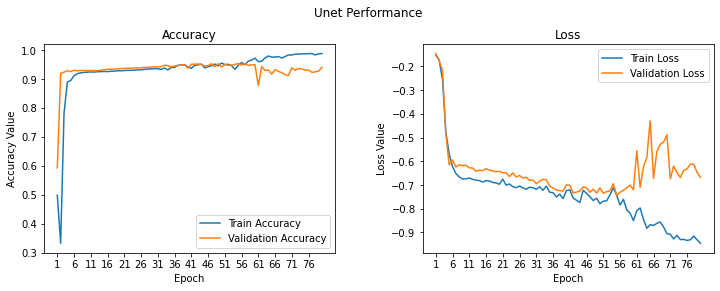

In [127]:

results = model.evaluate(X_test, y_test,verbose=1)

print("Loss of the model  is - test ", results[0])
print("Accuracy of the model is - test", results[1]*100, "%")


#plt.style.use('dark_background')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Unet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

**Making prediction**

In [128]:
predictions = model.predict(X_test,verbose=1)
predictions = (predictions > 0.5).astype(np.uint8)

2/2 [==============================] - 1s 199ms/step


(256, 256, 1)


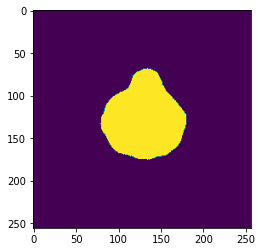

In [129]:
plt.imshow(predictions[15].squeeze(), vmin=0, vmax=1)

h = predictions[4]
print(h.shape)
               


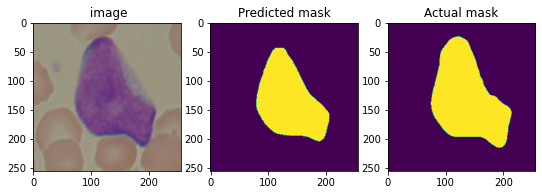

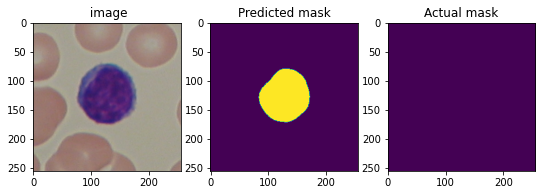

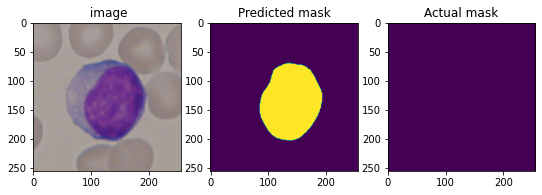

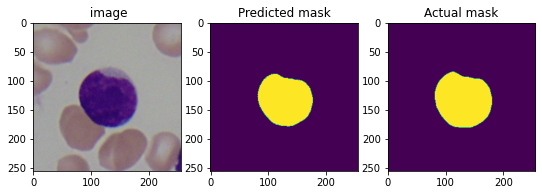

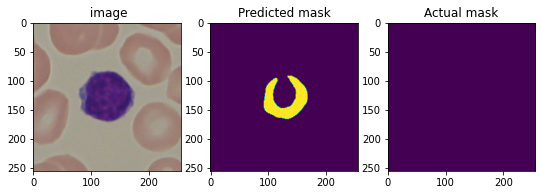

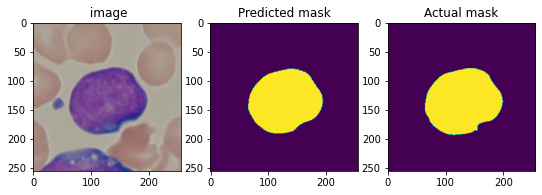

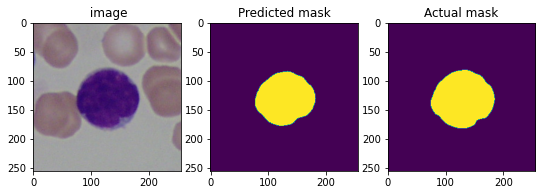

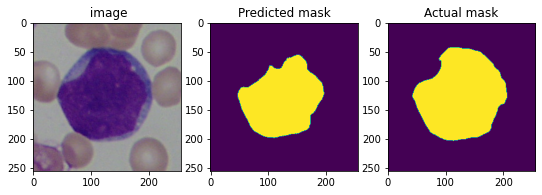

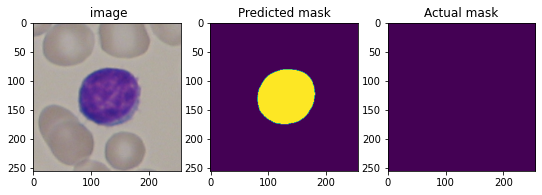

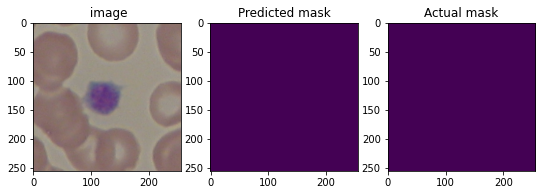

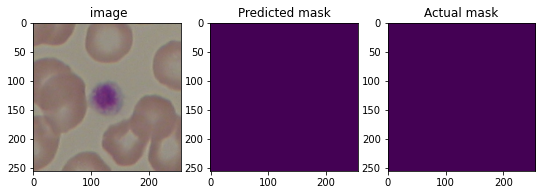

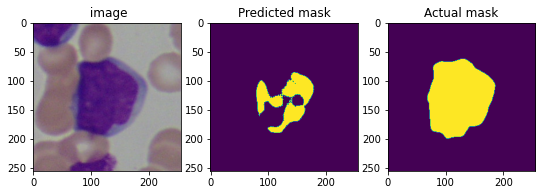

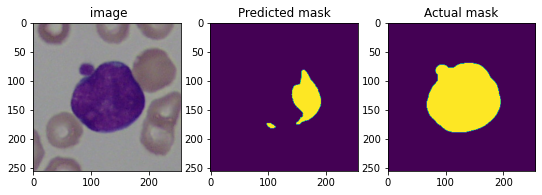

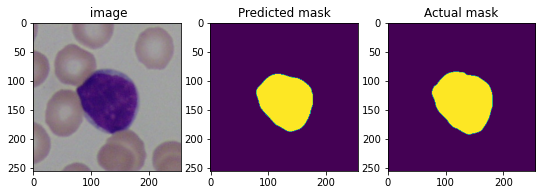

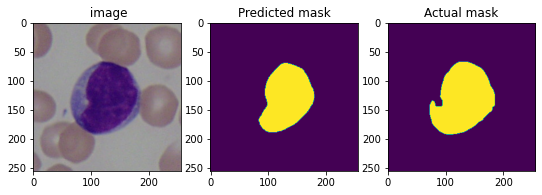

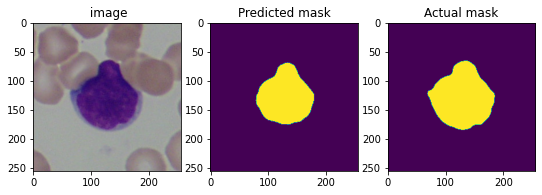

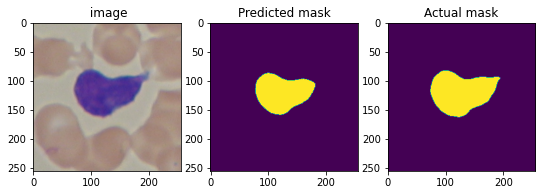

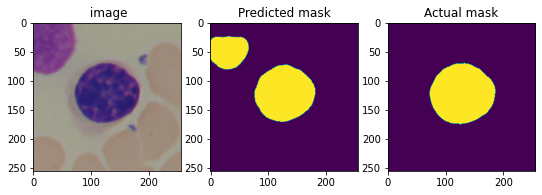

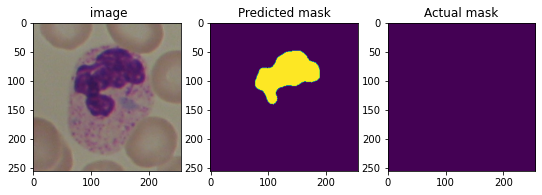

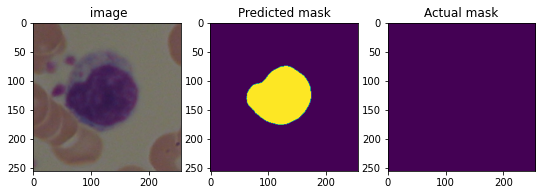

In [130]:
for i in range(20):

    img = X_test[i]
    predMask = predictions[i]
    groundTruth = y_test[i]

    plt.figure(figsize=(9,9))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title(' image')
    
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(predMask))
    plt.title('Predicted mask')
    
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(groundTruth))
    plt.title('Actual mask')

In [131]:

hist_df = pd.DataFrame(history.history)
hist_df['epoch_id'] = [i for i in range (1,len(hist_df)+1)]
hist_df=hist_df.reindex(columns= ['epoch_id', 'loss', 'accuracy','iou','dice_coef','val_loss','val_accuracy','val_iou','val_dice_coef'])
print(hist_df)



hist_df.to_csv(r'/content/ym/MyDrive/Colab Notebooks/Leukemia/Output/Model_hist.csv', index = False)

    epoch_id      loss  accuracy       iou  dice_coef  val_loss  val_accuracy  \
0          1 -0.151879  0.498237  0.082788   0.151879 -0.145096      0.592898   
1          2 -0.172109  0.332290  0.095230   0.172109 -0.174371      0.918736   
2          3 -0.253905  0.779735  0.147562   0.253905 -0.216757      0.923327   
3          4 -0.476440  0.889047  0.319679   0.476440 -0.484861      0.928031   
4          5 -0.569619  0.894146  0.404152   0.569619 -0.615381      0.925123   
..       ...       ...       ...       ...        ...       ...           ...   
75        76 -0.934459  0.987087  0.879234   0.934459 -0.632415      0.930857   
76        77 -0.931570  0.987599  0.876502   0.931570 -0.612074      0.922519   
77        78 -0.915943  0.982596  0.848572   0.915943 -0.613353      0.924236   
78        79 -0.932189  0.986504  0.876359   0.932189 -0.647579      0.926846   
79        80 -0.946685  0.987371  0.901542   0.946685 -0.668354      0.939568   

     val_iou  val_dice_coef